##### This notebook evaluates the results of training a logistic regression model on the theses in one topic and testing on the other topics #####

In [135]:
lang = 'sv'
word_kind = 'word'
tag_kind = 'pos'

lr_solver = 'liblinear'  # newton-cg, lbfgs, liblinear, sag, saga
lr_penalty = 'l2'  # l1, l2
lr_maxiter = 5000

infoline = f"""
- Train/test data: lang = **{lang}**, word = **{word_kind}**, tag = **{tag_kind}**
- Logistic regression: solver = **{lr_solver}**, penalty = **{lr_penalty}**, maxiter = **{lr_maxiter}**
"""

In [136]:
from sklearn.linear_model import LogisticRegression
def mk_logreg():
    return LogisticRegression(solver=lr_solver, penalty=lr_penalty, max_iter=lr_maxiter)

In [148]:
import pandas as pd
df    = pd.read_csv(f"data/theses-{lang}-downsampled.csv")
freqs = pd.read_csv(f"data/frequencies-{lang}-{word_kind}-{tag_kind}.csv")

# Drop junk columns and duplicates
df   .drop(['Unnamed: 0'], axis=1, inplace=True)
freqs.drop(['Unnamed: 0'], axis=1, inplace=True)
freqs.drop_duplicates(subset=['ID'], inplace=True)

ids = freqs['ID'].values

# Remove identifier from input
freqs.drop(['ID'], axis=1, inplace=True)

In [146]:
# Example rows of frequency dataframe
freqs[:2]

,af,aktör,all,alla,allas,alle,allesammans,allihop,allihopa,allom,...,VB+VB+DT,VB+VB+JJ,VB+VB+KN,VB+VB+MAD,VB+VB+NN,VB+VB+PL,VB+VB+PN,VB+VB+PP,VB+VB+SN,VB+VB+VB
0,0.0,0.0,0.000000,0.001837,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000845,0.000384,0.000461,0.001076,0.000922,0.000538,0.000999,0.001998,0.000154,0.000538
1,0.0,0.0,0.000251,0.001507,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001704,0.000477,0.001022,0.000477,0.001431,0.000477,0.000750,0.003544,0.000682,0.003408


In [139]:
# Get labels of the theses in the same order as the in the frequency table
labels_gender = [df[df['id'] == ident]['gender_composition'].values[0] for ident in ids]
labels_topic  = [df[df['id'] == ident]['topic'].values[0] for ident in ids]

from collections import Counter
print("Genders:", Counter(labels_gender))
print("Topics:", Counter(labels_topic))

Genders: Counter({'male': 1609, 'female': 1606})
Topics: Counter({'ekonomi': 1628, 'arkitektur': 816, 'humaniora': 692, 'naturvetenskap': 79})


In [140]:
# Divide input and labels into topics
from util import topics

freqs_by_topic = {
    top: [freqs.iloc[i] for i, t in enumerate(labels_topic) if t == top] 
    for top in topics
}
genderlabels_by_topic = {
    top: [labels_gender[i] for i, t in enumerate(labels_topic) if t == top] 
    for top in topics
}

In [141]:
from util import scale_frequencies

# Standardize inputs for all topics
for top in topics:
    freqs_by_topic[top] = scale_frequencies(freqs_by_topic[top])

In [142]:
# Fit a logistic regression model on the frequency matrix and gender labels of each topic 
logregs = {top: mk_logreg() for top in topics}
for top in topics:
    print(top, ":", len(freqs_by_topic[top]))
    logregs[top].fit(freqs_by_topic[top], genderlabels_by_topic[top])

humaniora : 692
arkitektur : 816
ekonomi : 1628
naturvetenskap : 79


In [147]:
from sklearn.metrics import accuracy_score
accuracies = {
    kind: {
        top: accuracy_score(genderlabels_by_topic[top], logregs[kind].predict(freqs_by_topic[top]))
        for top in topics
    }
    for kind in topics
}

from IPython.display import display, Markdown
out = [infoline]
out += [
    f'| Trained on  | ' + ' | '.join(f'<center>Tested on<br/>{top}</center>' for top in topics) + ' |',
    f'| ----------- | ' + ' | '.join(f'-----'                                for top in topics) + ' |',
] 
out += [
    f'| {kind} ({len(freqs_by_topic[kind])}) | ' + ' | '.join(f'<center>{accuracies[kind][top]:^.2f}</center>' for top in topics) + ' |'
    for kind in topics
]
display(Markdown('\n'.join(out)))


- Train/test data: lang = **sv**, word = **word**, tag = **pos**
- Logistic regression: solver = **liblinear**, penalty = **l2**, maxiter = **5000**

| Trained on  | <center>Tested on<br/>humaniora</center> | <center>Tested on<br/>arkitektur</center> | <center>Tested on<br/>ekonomi</center> | <center>Tested on<br/>naturvetenskap</center> |
| ----------- | ----- | ----- | ----- | ----- |
| humaniora (692) | <center>1.00</center> | <center>0.59</center> | <center>0.62</center> | <center>0.54</center> |
| arkitektur (816) | <center>0.61</center> | <center>1.00</center> | <center>0.62</center> | <center>0.68</center> |
| ekonomi (1628) | <center>0.65</center> | <center>0.62</center> | <center>1.00</center> | <center>0.77</center> |
| naturvetenskap (79) | <center>0.58</center> | <center>0.56</center> | <center>0.62</center> | <center>1.00</center> |

In [144]:
from sklearn.metrics import classification_report
from util import topics, genders

def print_report(kind):
    model = logregs[kind]
    for top in topics:
        print("#" * 80)
        print("Model trained on :", kind)
        print("Tested on: ", top)
        print(classification_report(genderlabels_by_topic[top], model.predict(freqs_by_topic[top]), labels=genders))

for kind in topics:
    print_report(kind)

################################################################################
Model trained on : humaniora
Tested on:  humaniora
              precision    recall  f1-score   support

      female       1.00      1.00      1.00       346
        male       1.00      1.00      1.00       346

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692

################################################################################
Model trained on : humaniora
Tested on:  arkitektur
              precision    recall  f1-score   support

      female       0.58      0.60      0.59       408
        male       0.59      0.58      0.58       408

    accuracy                           0.59       816
   macro avg       0.59      0.59      0.59       816
weighted avg       0.59      0.59      0.59       816

################################################################################


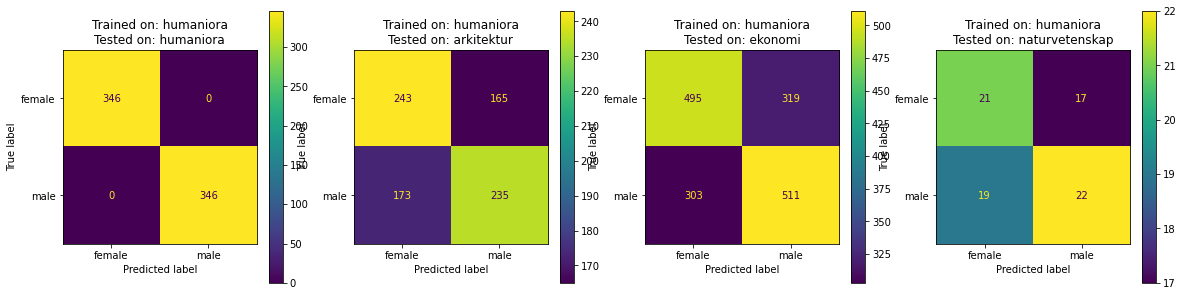

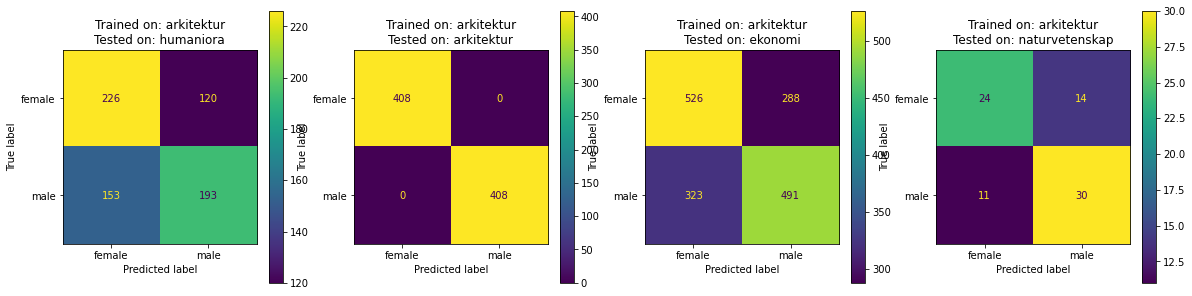

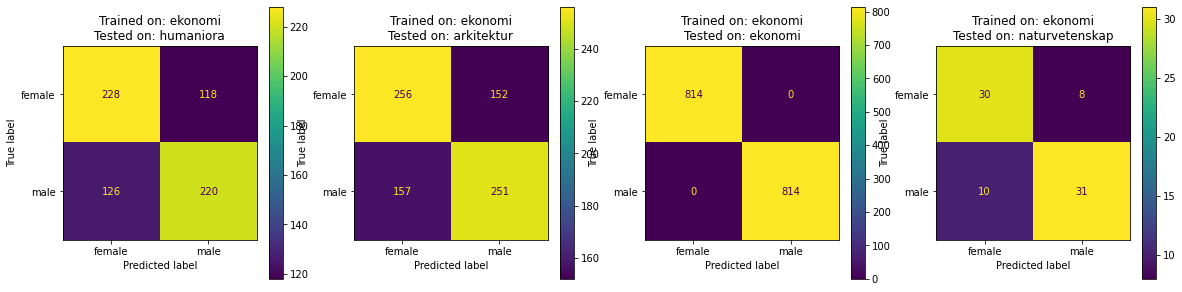

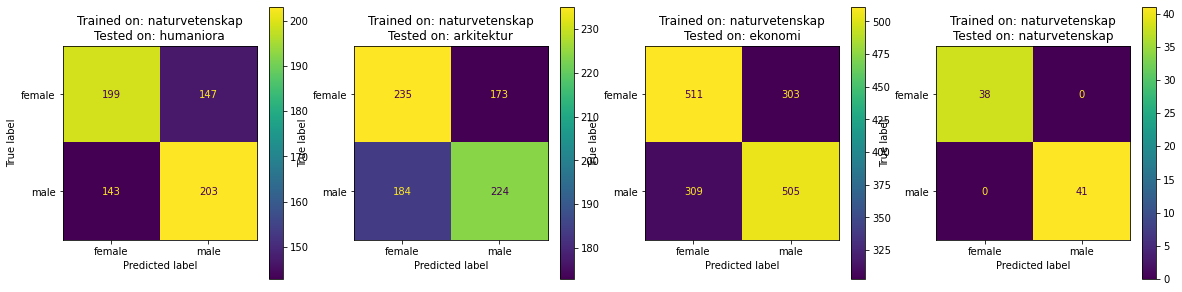

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def plot_confusion_matrices(kind):    
    model = logregs[kind]
    fig, axes = plt.subplots(nrows=1, ncols=len(topics), figsize=(20,5))
    for top, ax in zip(topics, axes.flatten()):
        ConfusionMatrixDisplay.from_estimator(model, freqs_by_topic[top], genderlabels_by_topic[top], ax=ax)
        ax.title.set_text("Trained on: " + kind + "\nTested on: " + top)

for top in topics:
    plot_confusion_matrices(top)